<a href="https://colab.research.google.com/github/olsem1/WP-3/blob/master/%22WP3_18.03.2021%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

!pip install pmdarima -q
#from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima


In [ ]:
course = pd.read_excel('RC_2002-2020.xlsx')
course = course.rename(columns={"data": "date"})
course = course.set_index('date')
course_m = course.resample('MS').mean()

# **Переменные**

In [ ]:
cpi = "month"
reg_names = ['ZAB']
data_do = "2020-12-01"
train_do = "2019-01-01"
mes = (pd.to_datetime(data_do).to_period('M') - pd.to_datetime(train_do).to_period('M')).n+1

result_rmse = pd.DataFrame(columns=['month/year', 'reg_names', 'data_do', 'train_do', 'mes', 'method', 'rmse'])

In [ ]:
data = pd.read_excel('cpi_reg.xls', sheet_name = cpi)
data = data.set_index('date')
data = data.interpolate(method='polynomial', order=2, axis=0)
data.isna().sum().sum()

268

In [ ]:
data.tail(6)

,RF,SFO,BEL,BRY,VLA,VOR,IVA,KAL,KOS,KUR,LIP,MOS,ORL,RYA,SMO,TAM,TVE,TUL,YAR,MOW,KAR,KOM,ARK,VLG,KAG,LEN,MUR,NGR,PSK,SPB,ADY,KLM,KRA,AST,VGG,ROS,DAG,ING,KAB,KAO,...,STA,BAS,MAR,MOR,TAT,UDM,CHV,PER,KIR,NIZ,ORE,PNZ,SAM,SAR,ULY,KUG,SVE,TYU,CHE,ALI,TUV,KHK,ALT,KYA,IRK,KEM,NVS,OMS,TOM,BUR,SAH,ZAB,KAM,PRI,KHA,AMU,MAG,SAK,JEW,CHU
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-08-01,99.96,100.06,99.95,99.82,99.65,99.93,100.02,99.97,99.94,99.53,99.98,99.77,99.92,99.86,99.51,99.93,99.56,99.76,99.68,99.97,99.88,99.76,99.75,99.68,100.26,99.81,99.66,99.87,100.08,99.86,99.99,99.76,100.42,99.60,99.59,99.85,100.40,99.98,100.11,100.02,...,99.92,99.99,100.01,99.89,100.04,99.91,99.70,100.20,99.96,99.70,100.30,100.08,100.05,99.74,100.03,100.18,99.97,99.94,100.12,100.35,99.79,100.16,100.06,99.80,100.32,99.80,100.00,100.10,99.69,99.96,100.15,100.17,100.43,100.02,100.02,100.37,99.58,99.92,100.03,100.05
2020-09-01,99.93,99.98,100.09,99.77,99.99,100.10,99.86,99.85,99.89,99.69,100.18,99.79,99.96,99.94,99.95,99.99,99.91,99.74,99.79,99.91,99.77,99.68,99.90,99.89,99.71,99.75,99.93,99.86,99.73,99.83,100.48,99.92,99.80,100.19,100.20,99.93,99.72,99.89,100.13,99.91,...,100.07,100.07,99.84,99.73,100.06,100.02,99.89,99.76,99.86,100.14,99.83,100.03,99.98,99.84,99.78,100.11,100.02,99.68,99.76,99.88,99.87,100.34,99.73,100.10,99.98,100.73,99.71,99.86,100.27,99.95,100.56,99.41,99.95,100.27,100.19,99.99,99.88,100.31,100.58,99.61
2020-10-01,100.43,100.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.05,100.40,100.42,100.46,100.38,100.57,100.35,100.57,100.68,100.22,100.30,NaN,100.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-01,100.71,100.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.84,100.63,100.92,101.52,101.01,100.81,100.56,100.86,100.87,100.34,100.64,NaN,100.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-01,100.83,100.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.71,100.91,100.81,100.43,100.89,100.82,100.71,100.06,100.81,100.73,100.80,NaN,100.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01,100.67,100.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.31,100.64,100.69,100.66,100.58,100.51,100.73,100.38,100.70,100.41,100.56,NaN,100.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **Проверка на стационарность**

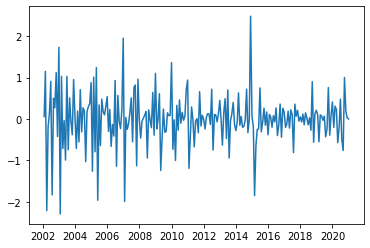

In [ ]:
# to log  and diff
data_st = pd.DataFrame(index = data.index[1:])
#data_st = pd.DataFrame(index = data.index)

for region in data.columns:
#  data_st[region] = np.log(data[region].values)
#  data_st[region] = np.diff(np.log(data[region].values))
  data_st[region] = np.diff(data[region].values)
#data_st=(data_st[:-10])

plt.plot(data_st[reg_names])

In [ ]:
"""
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
st = 0
notst = 0
p_value = 0.01
for num, region in enumerate(data_st.keys()):
  if region == 'RF':
    continue
  adf_result = adfuller(data_st[region])
  result_text = []
  result_text.append('ADF: {:.5}, '.format(adf_result[0]))
  result_text.append('p-val: {:.2}, '.format(adf_result[1]))
  if adf_result[1] < float(p_value):
      print('Регион:', region, 'p-val: {:.2}, '.format(adf_result[1]))
      st += 1
  else:
      print('Нестационарный ряд в регионе:', region, 'p-val: {:.2}, '.format(adf_result[1]))
      notst += 1
print('Нестационарных рядов всего:', notst, ' на уровне значимости , ', p_value)
"""

"\nfrom statsmodels.tsa.stattools import adfuller\n%matplotlib inline\nst = 0\nnotst = 0\np_value = 0.01\nfor num, region in enumerate(data_st.keys()):\n  if region == 'RF':\n    continue\n  adf_result = adfuller(data_st[region])\n  result_text = []\n  result_text.append('ADF: {:.5}, '.format(adf_result[0]))\n  result_text.append('p-val: {:.2}, '.format(adf_result[1]))\n  if adf_result[1] < float(p_value):\n      print('Регион:', region, 'p-val: {:.2}, '.format(adf_result[1]))\n      st += 1\n  else:\n      print('Нестационарный ряд в регионе:', region, 'p-val: {:.2}, '.format(adf_result[1]))\n      notst += 1\nprint('Нестационарных рядов всего:', notst, ' на уровне значимости , ', p_value)\n"

In [ ]:
#if use stationary data
#data=data_st

# для стационарных рядов
data_st = data_st[reg_names]
data_st = data_st[:data_do]
data_st = data_st.merge(course_m, left_on='date', right_on='date')
data_st['month'] = pd.DatetimeIndex(data_st.index).month
train_st = data_st[data_st.index < train_do]
test_st = data_st[data_st.index >= train_do]

# for ML
data = data[reg_names]
data = data[:data_do]
data = data.merge(course_m, left_on='date', right_on='date')
data['month'] = pd.DatetimeIndex(data.index).month

train = data[data.index < train_do]
test = data[data.index >= train_do]

In [ ]:
train[reg_names]

,ZAB
date,
2002-01-01,101.82
2002-02-01,101.88
2002-03-01,103.03
2002-04-01,100.82
2002-05-01,100.62
...,...
2018-08-01,100.26
2018-09-01,99.99
2018-10-01,100.89


# **ARIMA**

In [ ]:
# find best params for ARIMA
stepwise_model = auto_arima(train[reg_names], test='adf', start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, 
                                D=1, d=1, max_d=4, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, information_criterion = 'aic')
#                               out_of_sample_size = test.shape[0], scoring = 'mse', information_criterion = 'aicc')

stepwise_model.fit(train[reg_names])
future_forecast = stepwise_model.predict(n_periods=test.shape[0])
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns=[reg_names])

plt.plot(test[reg_names], label="test")
plt.plot(future_forecast[reg_names], label="forecast")
plt.legend()

print('rmse: {:.4f}'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5 / 
                                    np.mean(test[reg_names].values) * 100))


In [ ]:
result = pd.DataFrame(np.array(future_forecast), index = test.index, columns=['ARIMA'])
result_arima = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'ARIMA', 'rmse': mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5} 
result_rmse = result_rmse.append(result_arima, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[ZAB],2020-12-01,2019-01-01,24,ARIMA,0.345872


# **ARIMAX**

In [ ]:
exogenous_features = ['month', 'curs']

In [ ]:
# find best params for ARIMAX
stepwise_model = auto_arima(train[reg_names], exogenous = train[exogenous_features], test='adf', start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True,
                            d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, information_criterion = 'aic')
#                            out_of_sample_size = test.shape[0], scoring = 'mse', information_criterion = 'aicc')
  
stepwise_model.fit(train[reg_names], exogenous = train[exogenous_features])
future_forecast = stepwise_model.predict(n_periods=test.shape[0], exogenous = test[exogenous_features])
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns=[reg_names])

plt.plot(test[reg_names], label="test")
plt.plot(future_forecast[reg_names], label="forecast")
plt.legend()

print('rmse: {:.4f}'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5 / 
                                    np.mean(test[reg_names].values) * 100))

In [ ]:
result['ARIMAX']=pd.DataFrame(np.array(future_forecast), index = test.index, columns=['ARIMAX'])

In [ ]:
result_arimax = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'ARIMAX', 
                'rmse': mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5} 
result_rmse = result_rmse.append(result_arimax, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[ZAB],2020-12-01,2019-01-01,24,ARIMA,0.345872
1,month,[ZAB],2020-12-01,2019-01-01,24,ARIMAX,0.388263


# **Feature Engineering**

In [ ]:
data_lags = pd.DataFrame()

data_lags['curs'] = data['curs'].values
data_lags['t'] = data[reg_names].values
for i in {1, 6, 12}:
    data_lags['t-'+str(i)] = data[reg_names].shift(i).values
data_lags.index = data.index
data_lags = data_lags[12:]
data_lags['month'] = pd.DatetimeIndex(data_lags.index).month
data_lags

,curs,t,t-1,t-12,t-6,month
date,,,,,,
2003-01-01,31.816165,103.05,101.32,101.82,101.68,1
2003-02-01,31.698979,100.76,103.05,101.88,99.85,2
2003-03-01,31.453290,101.79,100.76,103.03,100.35,3
2003-04-01,31.211786,101.08,101.79,100.82,100.62,4
2003-05-01,30.907055,101.04,101.08,100.62,101.74,5
...,...,...,...,...,...,...
2020-08-01,73.798110,100.17,100.66,100.00,100.42,8
2020-09-01,75.727986,99.41,100.17,99.76,100.73,9
2020-10-01,77.663548,100.41,99.41,100.52,100.96,10


In [ ]:
df=data_lags
df.reset_index(drop=False, inplace=True)
lag_features = ["t", "curs"]
window1 = 3
window2 = 6
window3 = 12

df_rolled_3m = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_6m = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_12m = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3m = df_rolled_3m.mean().shift(1).reset_index().astype(np.float32)
df_mean_6m = df_rolled_6m.mean().shift(1).reset_index().astype(np.float32)
df_mean_12m = df_rolled_12m.mean().shift(1).reset_index().astype(np.float32)

df_std_3m = df_rolled_3m.std().shift(1).reset_index().astype(np.float32)
df_std_6m = df_rolled_6m.std().shift(1).reset_index().astype(np.float32)
df_std_12m = df_rolled_12m.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3m[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_6m[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_12m[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3m[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_6m[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_12m[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("date", drop=True, inplace=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


In [ ]:
data = df
data_not = data.drop('t', axis=1)
train = data[data.index < train_do]
test = data[data.index >= train_do]

X_train = train.drop(['t'], axis=1).values
y_train = train[['t']].values.ravel()
X_test = test.drop(['t'], axis=1).values
y_test = test[['t']].values.ravel()

In [ ]:
# scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_m = scaler.transform(X_train)
X_test_m = scaler.transform(X_test)

In [ ]:
result['y_test']=pd.DataFrame(np.array(y_test), index = test.index, columns=['y_test'])
result

# **KNeighborsRegressor**

In [ ]:
!pip install mglearn -q

     |████████████████████████████████| 542kB 6.0MB/s 


In [ ]:
from sklearn.datasets import make_blobs
import mglearn
from sklearn.neighbors import KNeighborsRegressor

# instantiate the model 
KNmodel = KNeighborsRegressor(n_neighbors=5)
# fit the model using the training data and training targets
KNmodel.fit(X_train, y_train)

print("Training set score: {:.2f}".format(KNmodel.score(X_train, y_train)))
print("Test set score: {:.2f}".format(KNmodel.score(X_test, y_test)))

forecast = KNmodel.predict(X_test)
print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.56
Test set score: -0.01
rmse: 0.3337
normed rmse: 0.3325%


In [ ]:
result['KNR']=pd.DataFrame(np.array(forecast), index = test.index, columns=['KNR'])
result_KNR = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'KNR', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_KNR, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[ZAB],2020-12-01,2019-01-01,24,ARIMA,0.345872
1,month,[ZAB],2020-12-01,2019-01-01,24,ARIMAX,0.388263
2,month,[ZAB],2020-12-01,2019-01-01,24,KNR,0.333741


# **OLS**

In [ ]:
# scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_m = scaler.transform(X_train)
X_test_m = scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train_m, y_train)
print("Training set score: {:.2f}".format(lr.score(X_train_m, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test_m, y_test)))

forecast = lr.predict(X_test_m)
print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.40
Test set score: -0.70
rmse: 0.4324
normed rmse: 0.4308%


In [ ]:
result['OLS']=pd.DataFrame(np.array(forecast), index = test.index, columns=['OLS'])
result_OLS = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'OLS', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_OLS, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[ZAB],2020-12-01,2019-01-01,24,ARIMA,0.345872
1,month,[ZAB],2020-12-01,2019-01-01,24,ARIMAX,0.388263
2,month,[ZAB],2020-12-01,2019-01-01,24,KNR,0.333741
3,month,[ZAB],2020-12-01,2019-01-01,24,OLS,0.432416


# **Ridge (l2-regularisation)**

In [ ]:
ridge = Ridge().fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))

forecast = ridge.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.39
Test set score: -0.72
rmse: 0.43547
normed rmse: 0.43%


In [ ]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(MinMaxScaler(), Ridge())
GSRidge = GridSearchCV(pipe, param_grid, cv=5)
GSRidge.fit(X_train, y_train)
print("Score without poly features: {:.2f}".format(GSRidge.score(X_test, y_test)))

print("Training set score: {:.2f}".format(GSRidge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(GSRidge.score(X_test, y_test)))

forecast = GSRidge.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))


Score without poly features: -0.03
Training set score: 0.37
Test set score: -0.03
rmse: 0.33734
normed rmse: 0.34%


In [ ]:
result['Ridge']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Ridge'])
result_Ridge = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'Ridge', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_Ridge, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[ZAB],2020-12-01,2019-01-01,24,ARIMA,0.345872
1,month,[ZAB],2020-12-01,2019-01-01,24,ARIMAX,0.388263
2,month,[ZAB],2020-12-01,2019-01-01,24,KNR,0.333741
3,month,[ZAB],2020-12-01,2019-01-01,24,OLS,0.432416
4,month,[ZAB],2020-12-01,2019-01-01,24,Ridge,0.337345


# **Lasso (l1-regularisation)**

In [ ]:
# scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_m = scaler.transform(X_train)
X_test_m = scaler.transform(X_test)

In [ ]:
# we increase the default setting of "max_iter",
# otherwise the model would warn us that we should increase max_iter.
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train_m, y_train)
print("Training set score: {:.2f}".format(lasso001.score(X_train_m, y_train)))
print("Test set score: {:.2f}".format(lasso001.score(X_test_m, y_test)))
print("Number of features used:", np.sum(lasso001.coef_ != 0))

forecast = lasso001.predict(X_test_m)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.31
Test set score: 0.14
Number of features used: 5
rmse: 0.30674
normed rmse: 0.31%


In [ ]:
result['Lasso']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Lasso'])
result_Lasso = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'Lasso', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_Lasso, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[ZAB],2020-12-01,2019-01-01,24,ARIMA,0.345872
1,month,[ZAB],2020-12-01,2019-01-01,24,ARIMAX,0.388263
2,month,[ZAB],2020-12-01,2019-01-01,24,KNR,0.333741
3,month,[ZAB],2020-12-01,2019-01-01,24,OLS,0.432416
4,month,[ZAB],2020-12-01,2019-01-01,24,Ridge,0.337345
5,month,[ZAB],2020-12-01,2019-01-01,24,Lasso,0.306738


# **ElasticNet (l1+l2-regularisation)**

In [ ]:
from sklearn.linear_model import ElasticNet
ENmodel = ElasticNet(alpha=0.1, max_iter=100000).fit(X_train, y_train)

print("Training set score: {:.2f}".format(ENmodel.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ENmodel.score(X_test, y_test)))
print("Number of features used:", np.sum(ENmodel.coef_ != 0))

forecast = ENmodel.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.32
Test set score: -0.03
Number of features used: 7
rmse: 0.33659
normed rmse: 0.34%


In [ ]:
result['ElasticNet']=pd.DataFrame(np.array(forecast), index = test.index, columns=['ElasticNet'])
result_ElasticNet = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'ElasticNet', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_ElasticNet, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[ZAB],2020-12-01,2019-01-01,24,ARIMA,0.345872
1,month,[ZAB],2020-12-01,2019-01-01,24,ARIMAX,0.388263
2,month,[ZAB],2020-12-01,2019-01-01,24,KNR,0.333741
3,month,[ZAB],2020-12-01,2019-01-01,24,OLS,0.432416
4,month,[ZAB],2020-12-01,2019-01-01,24,Ridge,0.337345
5,month,[ZAB],2020-12-01,2019-01-01,24,Lasso,0.306738
6,month,[ZAB],2020-12-01,2019-01-01,24,ElasticNet,0.336595


# **DecisionTree**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=5, random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

forecast = tree.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

result['DecisionTree']=pd.DataFrame(np.array(forecast), index = test.index, columns=['DecisionTree'])

result_DT = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'DT', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_DT, ignore_index = True) 
result_rmse

Accuracy on training set: 0.683
Accuracy on test set: -6.323
rmse: 0.89763
normed rmse: 0.89%


,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[ZAB],2020-12-01,2019-01-01,24,ARIMA,0.345872
1,month,[ZAB],2020-12-01,2019-01-01,24,ARIMAX,0.388263
2,month,[ZAB],2020-12-01,2019-01-01,24,KNR,0.333741
3,month,[ZAB],2020-12-01,2019-01-01,24,OLS,0.432416
4,month,[ZAB],2020-12-01,2019-01-01,24,Ridge,0.337345
5,month,[ZAB],2020-12-01,2019-01-01,24,Lasso,0.306738
6,month,[ZAB],2020-12-01,2019-01-01,24,ElasticNet,0.336595
7,month,[ZAB],2020-12-01,2019-01-01,24,DT,0.897630


# **GridSearch DecisionTree**

Parameter grid:
{'max_depth': [1, 2, 3, 5, 10], 'min_samples_leaf': [1, 2, 3, 50, 100], 'max_leaf_nodes': [10, 20, 30, 500, 1000]}
Test set score: -0.66
Best parameters: {'max_depth': 1, 'max_leaf_nodes': 10, 'min_samples_leaf': 50}
Best estimator:
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=1,
                      max_features=None, max_leaf_nodes=10,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=50, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
rmse: 0.4273
normed rmse: 0.4257%
Accuracy on training set: 0.169
Accuracy on test set: -0.660


,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[ZAB],2020-12-01,2019-01-01,24,ARIMA,0.345872
1,month,[ZAB],2020-12-01,2019-01-01,24,ARIMAX,0.388263
2,month,[ZAB],2020-12-01,2019-01-01,24,KNR,0.333741
3,month,[ZAB],2020-12-01,2019-01-01,24,OLS,0.432416
4,month,[ZAB],2020-12-01,2019-01-01,24,Ridge,0.337345
5,month,[ZAB],2020-12-01,2019-01-01,24,Lasso,0.306738
6,month,[ZAB],2020-12-01,2019-01-01,24,ElasticNet,0.336595
7,month,[ZAB],2020-12-01,2019-01-01,24,DT,0.897630
8,month,[ZAB],2020-12-01,2019-01-01,24,GSDT,0.427329


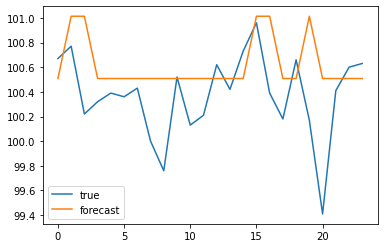

In [ ]:
param_grid = {'max_depth': [1, 2, 3, 5, 10],
              'min_samples_leaf': [1, 2, 3, 50, 100],
              'max_leaf_nodes': [10, 20, 30, 500, 1000]}
print("Parameter grid:\n{}".format(param_grid))

GSDT = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=30)
GSDT.fit(X_train, y_train)

print("Test set score: {:.2f}".format(GSDT.score(X_test, y_test)))
print("Best parameters: {}".format(GSDT.best_params_))
print("Best estimator:\n{}".format(GSDT.best_estimator_))

# make predictions
GSDT_forecast = GSDT.predict(X_test)

plt.plot(y_test, label='true')
plt.plot(GSDT_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, GSDT_forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, GSDT_forecast) ** 0.5) / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(GSDT.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(GSDT.score(X_test, y_test)))

result['GSDT']=pd.DataFrame(np.array(GSDT_forecast), index = test.index, columns=['GSDT'])

result_GSDT = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'GSDT', 
                'rmse': mean_squared_error(y_test, GSDT_forecast) ** 0.5} 
result_rmse = result_rmse.append(result_GSDT, ignore_index = True) 
result_rmse

# **Random Forest**

rmse: 0.38404
normed rmse: 0.383%
Accuracy on training set: 0.903
Accuracy on test set: -0.341


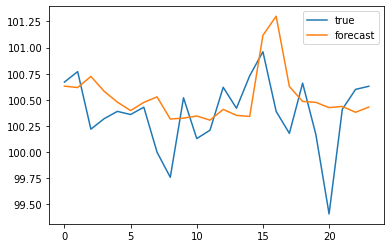

In [ ]:
from sklearn.ensemble import RandomForestRegressor

RFmodel = RandomForestRegressor(n_estimators=500, random_state=42)
RFmodel.fit(X_train, y_train)
forecast = RFmodel.predict(X_test)

plt.plot(y_test, label='true')
plt.plot(forecast, label='forecast')
plt.legend()

print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.3f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(RFmodel.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(RFmodel.score(X_test, y_test)))

In [ ]:
result['Random Forest']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Random Forest'])
result_RF = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'RF', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_RF, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[ZAB],2020-12-01,2019-01-01,24,ARIMA,0.345872
1,month,[ZAB],2020-12-01,2019-01-01,24,ARIMAX,0.388263
2,month,[ZAB],2020-12-01,2019-01-01,24,KNR,0.333741
3,month,[ZAB],2020-12-01,2019-01-01,24,OLS,0.432416
4,month,[ZAB],2020-12-01,2019-01-01,24,Ridge,0.337345
5,month,[ZAB],2020-12-01,2019-01-01,24,Lasso,0.306738
6,month,[ZAB],2020-12-01,2019-01-01,24,ElasticNet,0.336595
7,month,[ZAB],2020-12-01,2019-01-01,24,DT,0.897630
8,month,[ZAB],2020-12-01,2019-01-01,24,GSDT,0.427329
9,month,[ZAB],2020-12-01,2019-01-01,24,RF,0.384041


In [ ]:
RFmodel.feature_importances_

array([0.03024817, 0.16111794, 0.06358391, 0.04026805, 0.13826781,
       0.09303445, 0.02765107, 0.04716027, 0.05362117, 0.03037603,
       0.04820842, 0.03127431, 0.02641584, 0.04214727, 0.10019693,
       0.031879  , 0.03454937])

# **Plot_features**

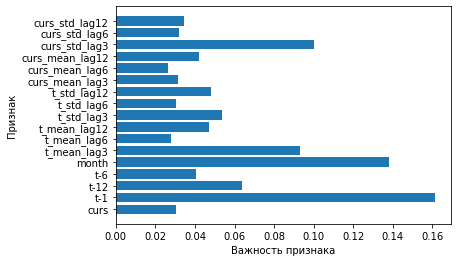

In [ ]:
def plot_features(model):
  n_features = data_not.shape[1]
  plt.barh(range(n_features), model.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), data_not.columns)
  plt.xlabel('Важность признака')
  plt.ylabel('Признак')
plot_features(RFmodel)

In [ ]:
def plot_features_GS(model):
  n_features = data_not.shape[1]
  plt.barh(range(n_features), model.best_estimator_.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), data_not.columns)
  plt.xlabel('Важность признака')
  plt.ylabel('Признак')

# **GSRF**

Parameter grid:
{'n_estimators': [1, 10, 50, 100, 200, 300]}
Test set score: -0.29
Best parameters: {'n_estimators': 200}
Best estimator:
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
rmse: 0.3766
normed rmse: 0.3752%
Accuracy on training set: 0.905
Accuracy on test set: -0.289


,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[ZAB],2020-12-01,2019-01-01,24,ARIMA,0.345872
1,month,[ZAB],2020-12-01,2019-01-01,24,ARIMAX,0.388263
2,month,[ZAB],2020-12-01,2019-01-01,24,KNR,0.333741
3,month,[ZAB],2020-12-01,2019-01-01,24,OLS,0.432416
4,month,[ZAB],2020-12-01,2019-01-01,24,Ridge,0.337345
5,month,[ZAB],2020-12-01,2019-01-01,24,Lasso,0.306738
6,month,[ZAB],2020-12-01,2019-01-01,24,ElasticNet,0.336595
7,month,[ZAB],2020-12-01,2019-01-01,24,DT,0.897630
8,month,[ZAB],2020-12-01,2019-01-01,24,GSDT,0.427329
9,month,[ZAB],2020-12-01,2019-01-01,24,RF,0.384041


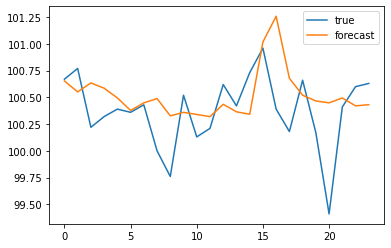

In [ ]:
param_grid = {'n_estimators': [1, 10, 50, 100, 200, 300]}
print("Parameter grid:\n{}".format(param_grid))

GSRF = GridSearchCV(RandomForestRegressor(), param_grid, cv=30)
GSRF.fit(X_train, y_train)

print("Test set score: {:.2f}".format(GSRF.score(X_test, y_test)))
print("Best parameters: {}".format(GSRF.best_params_))
print("Best estimator:\n{}".format(GSRF.best_estimator_))

# make predictions
GSRF_forecast = GSRF.predict(X_test)

plt.plot(y_test, label='true')
plt.plot(GSRF_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, GSRF_forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, GSRF_forecast) ** 0.5) / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(GSRF.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(GSRF.score(X_test, y_test)))

result['GSRF']=pd.DataFrame(np.array(GSRF_forecast), index = test.index, columns=['GSRF'])

result_GSRF = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'GSRF', 
                'rmse': mean_squared_error(y_test, GSRF_forecast) ** 0.5} 
result_rmse = result_rmse.append(result_GSRF, ignore_index = True) 
result_rmse

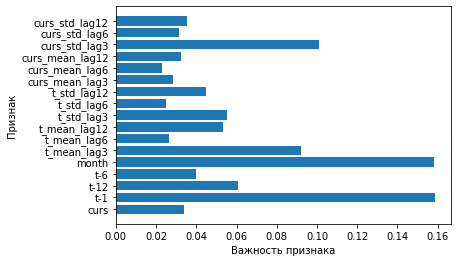

In [ ]:
plot_features_GS(GSRF)

# **Slide test**

In [ ]:
"""
from datetime import datetime
from dateutil.relativedelta import relativedelta
#startdate = pd.to_datetime(data_do)
startdate = pd.to_datetime(train_do)+ relativedelta(months=1)

#print('Today: ', startdate.strftime('%Y-%m-%d'))
#print(date_after_month.strftime('%Y-%m-%d'))
#startdate = str(startdate)[:10]
startdate
"""

"\nfrom datetime import datetime\nfrom dateutil.relativedelta import relativedelta\n#startdate = pd.to_datetime(data_do)\nstartdate = pd.to_datetime(train_do)+ relativedelta(months=1)\n\n#print('Today: ', startdate.strftime('%Y-%m-%d'))\n#print(date_after_month.strftime('%Y-%m-%d'))\n#startdate = str(startdate)[:10]\nstartdate\n"

In [ ]:
"""
#forecast = RFmodel.predict(X_test)
#slide_test = test[test.index == train_do][data_not.columns.values].values
#print(slide_test)
slide_test = X_test
forecast = []
forecast.append(RFmodel.predict(slide_test)[0])

for i in range(test.shape[0] - 1):
  
  slide_test_next = slide_test.copy()
  slide_test_next[0, 1] = forecast[-1]

  slide_test_next[0, 0] += 1
  slide_test_next[0, 2:] = slide_test[0, 1:-1]
  
  #print(slide_test_next)
  slide_test = slide_test_next.copy()

  forecast.append(RFmodel.predict(slide_test)[0])

forecast = np.array(forecast)

plt.plot(y_test, label='true')
plt.plot(forecast, label='forecast')
plt.legend()

print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, forecast) ** 0.5) / np.mean(y_test) * 100))
"""

"\n#forecast = RFmodel.predict(X_test)\n#slide_test = test[test.index == train_do][data_not.columns.values].values\n#print(slide_test)\nslide_test = X_test\nforecast = []\nforecast.append(RFmodel.predict(slide_test)[0])\n\nfor i in range(test.shape[0] - 1):\n  \n  slide_test_next = slide_test.copy()\n  slide_test_next[0, 1] = forecast[-1]\n\n  slide_test_next[0, 0] += 1\n  slide_test_next[0, 2:] = slide_test[0, 1:-1]\n  \n  #print(slide_test_next)\n  slide_test = slide_test_next.copy()\n\n  forecast.append(RFmodel.predict(slide_test)[0])\n\nforecast = np.array(forecast)\n\nplt.plot(y_test, label='true')\nplt.plot(forecast, label='forecast')\nplt.legend()\n\nprint('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))\nprint('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, forecast) ** 0.5) / np.mean(y_test) * 100))\n"

In [ ]:
"""result_RFST = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'RFST', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_RFST, ignore_index = True) 
result_rmse
"""

"result_RFST = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'RFST', \n                'rmse': mean_squared_error(y_test, forecast) ** 0.5} \nresult_rmse = result_rmse.append(result_RFST, ignore_index = True) \nresult_rmse\n"

# **Stratified K-Fold cross-validation and other strategies**

In [ ]:
"""
from sklearn.model_selection import KFold
kfold = KFold(n_splits=3)

print("Cross-validation scores:\n{}".format(
      cross_val_score(model, X_train, y_train, cv=kfold)))

kfold = KFold(n_splits=3, shuffle=True, random_state=42)
print("Cross-validation scores:\n{}".format(
    cross_val_score(model, X_train, y_train, cv=kfold)))
"""

'\nfrom sklearn.model_selection import KFold\nkfold = KFold(n_splits=3)\n\nprint("Cross-validation scores:\n{}".format(\n      cross_val_score(model, X_train, y_train, cv=kfold)))\n\nkfold = KFold(n_splits=3, shuffle=True, random_state=42)\nprint("Cross-validation scores:\n{}".format(\n    cross_val_score(model, X_train, y_train, cv=kfold)))\n'

# **GradientBoostingRegressor**

In [ ]:
from xgboost import XGBRegressor

rmse: 0.5456
normed rmse: 0.5436%
Accuracy on training set: -0.326
Accuracy on test set: -1.705


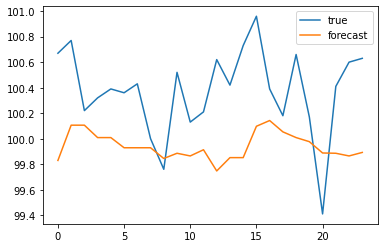

In [ ]:
xgb_model = XGBRegressor (objective ='reg:squarederror', n_estimators=50, max_depth=3)
xgb_model.fit(X_train, y_train, verbose=False)
# make predictions
xgb_forecast = xgb_model.predict(X_test)
xgb_model.feature_importances_
plt.plot(y_test, label='true')
plt.plot(xgb_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, xgb_forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, xgb_forecast) ** 0.5) / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(xgb_model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(xgb_model.score(X_test, y_test)))

In [ ]:
result['GradientBoosting']=pd.DataFrame(np.array(xgb_forecast), index = test.index, columns=['GradientBoosting'])
result_XGB = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'XGB', 
                'rmse': mean_squared_error(y_test, xgb_forecast) ** 0.5} 
result_rmse = result_rmse.append(result_XGB, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[ZAB],2020-12-01,2019-01-01,24,ARIMA,0.345872
1,month,[ZAB],2020-12-01,2019-01-01,24,ARIMAX,0.388263
2,month,[ZAB],2020-12-01,2019-01-01,24,KNR,0.333741
3,month,[ZAB],2020-12-01,2019-01-01,24,OLS,0.432416
4,month,[ZAB],2020-12-01,2019-01-01,24,Ridge,0.337345
5,month,[ZAB],2020-12-01,2019-01-01,24,Lasso,0.306738
6,month,[ZAB],2020-12-01,2019-01-01,24,ElasticNet,0.336595
7,month,[ZAB],2020-12-01,2019-01-01,24,DT,0.897630
8,month,[ZAB],2020-12-01,2019-01-01,24,GSDT,0.427329
9,month,[ZAB],2020-12-01,2019-01-01,24,RF,0.384041


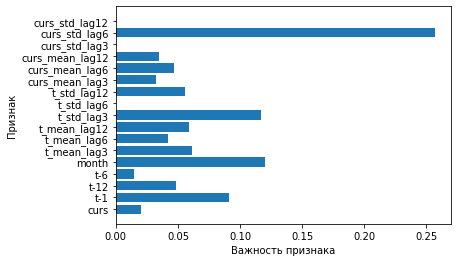

In [ ]:
plot_features(xgb_model)

# **Grid Search XGB**

Parameter grid:
{'max_depth': [1, 2, 3, 5, 10], 'n_estimators': [1, 10, 50, 100, 200, 300, 500]}
Test set score: 0.07
Best parameters: {'max_depth': 1, 'n_estimators': 100}
Best estimator:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=1, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)
rmse: 0.3205
normed rmse: 0.3193%
Accuracy on training set: 0.510
Accuracy on test set: 0.066


,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[ZAB],2020-12-01,2019-01-01,24,ARIMA,0.345872
1,month,[ZAB],2020-12-01,2019-01-01,24,ARIMAX,0.388263
2,month,[ZAB],2020-12-01,2019-01-01,24,KNR,0.333741
3,month,[ZAB],2020-12-01,2019-01-01,24,OLS,0.432416
4,month,[ZAB],2020-12-01,2019-01-01,24,Ridge,0.337345
5,month,[ZAB],2020-12-01,2019-01-01,24,Lasso,0.306738
6,month,[ZAB],2020-12-01,2019-01-01,24,ElasticNet,0.336595
7,month,[ZAB],2020-12-01,2019-01-01,24,DT,0.897630
8,month,[ZAB],2020-12-01,2019-01-01,24,GSDT,0.427329
9,month,[ZAB],2020-12-01,2019-01-01,24,RF,0.384041


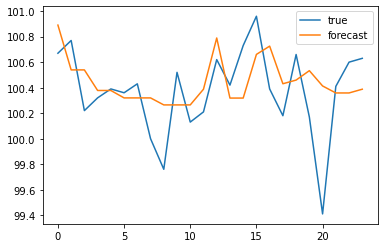

In [ ]:
param_grid = {'max_depth': [1, 2, 3, 5, 10],
              'n_estimators': [1, 10, 50, 100, 200, 300, 500]}
print("Parameter grid:\n{}".format(param_grid))

GSXGB = GridSearchCV(XGBRegressor(objective ='reg:squarederror'), param_grid, cv=30)
GSXGB.fit(X_train, y_train, verbose=False)

print("Test set score: {:.2f}".format(GSXGB.score(X_test, y_test)))
print("Best parameters: {}".format(GSXGB.best_params_))
print("Best estimator:\n{}".format(GSXGB.best_estimator_))

# make predictions
GSXGB_forecast = GSXGB.predict(X_test)
plt.plot(y_test, label='true')
plt.plot(GSXGB_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, GSXGB_forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, GSXGB_forecast) ** 0.5) / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(GSXGB.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(GSXGB.score(X_test, y_test)))

result['GSXGB']=pd.DataFrame(np.array(GSXGB_forecast), index = test.index, columns=['GSXGB'])

result_GSXGB = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'GSXGB', 
                'rmse': mean_squared_error(y_test, GSXGB_forecast) ** 0.5} 
result_rmse = result_rmse.append(result_GSXGB, ignore_index = True) 
result_rmse

In [ ]:
feature_importances = GSXGB.best_estimator_.feature_importances_
feature_importances

array([0.        , 0.11521213, 0.07577062, 0.        , 0.09656932,
       0.09124381, 0.09189238, 0.15969503, 0.13110985, 0.        ,
       0.        , 0.03748888, 0.09124424, 0.05364842, 0.05612529,
       0.        , 0.        ], dtype=float32)

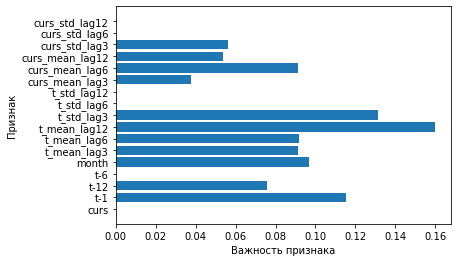

In [ ]:
plot_features_GS(GSXGB)

# **Results**

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[ZAB],2020-12-01,2019-01-01,24,ARIMA,0.345872
1,month,[ZAB],2020-12-01,2019-01-01,24,ARIMAX,0.388263
2,month,[ZAB],2020-12-01,2019-01-01,24,KNR,0.333741
3,month,[ZAB],2020-12-01,2019-01-01,24,OLS,0.432416
4,month,[ZAB],2020-12-01,2019-01-01,24,Ridge,0.337345
5,month,[ZAB],2020-12-01,2019-01-01,24,Lasso,0.306738
6,month,[ZAB],2020-12-01,2019-01-01,24,ElasticNet,0.336595
7,month,[ZAB],2020-12-01,2019-01-01,24,DT,0.897630
8,month,[ZAB],2020-12-01,2019-01-01,24,GSDT,0.427329
9,month,[ZAB],2020-12-01,2019-01-01,24,RF,0.384041


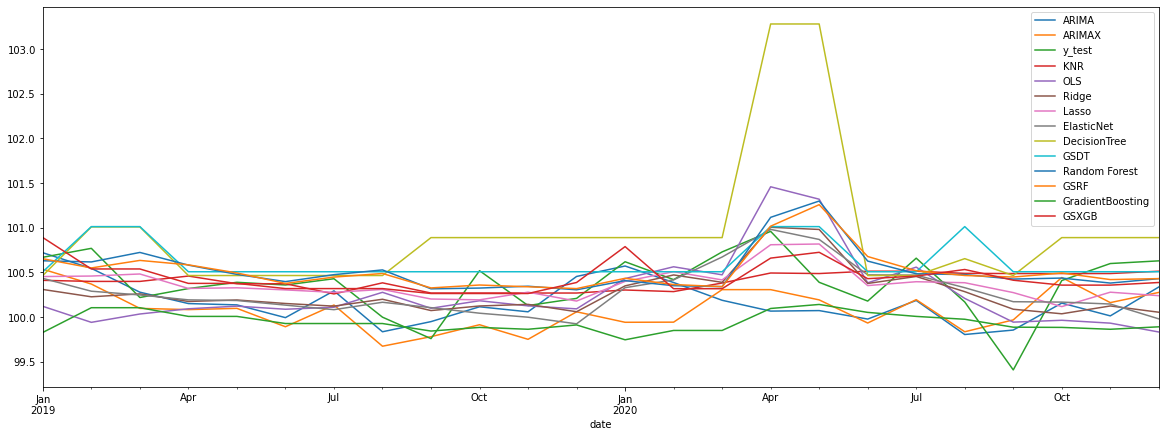

In [ ]:
result.plot(figsize=(20, 7))
result_rmse

In [ ]:
result

,ARIMA,ARIMAX,y_test,KNR,OLS,Ridge,Lasso,ElasticNet,DecisionTree,GSDT,Random Forest,GSRF,GradientBoosting,GSXGB
date,,,,,,,,,,,,,,
2019-01-01,100.720680,100.536477,100.67,100.412,100.121306,100.309911,100.454372,100.433970,100.465870,100.508148,100.63090,100.65370,99.829247,100.890511
2019-02-01,100.545800,100.370490,100.77,100.400,99.942129,100.227875,100.460072,100.290325,101.009412,101.013095,100.61786,100.55075,100.105843,100.539268
2019-03-01,100.279538,100.098313,100.22,100.400,100.035418,100.260709,100.483117,100.248471,101.009412,101.013095,100.72420,100.63495,100.105843,100.539268
2019-04-01,100.152115,100.084600,100.32,100.460,100.093704,100.175589,100.321335,100.193502,100.465870,100.508148,100.58240,100.58535,100.008507,100.377892
2019-05-01,100.137364,100.098468,100.39,100.374,100.123372,100.192229,100.328624,100.186346,100.465870,100.508148,100.47868,100.49465,100.008507,100.377892
2019-06-01,99.994762,99.892890,100.36,100.374,100.088675,100.153003,100.304999,100.134785,100.465870,100.508148,100.39772,100.37755,99.928810,100.319656
2019-07-01,100.294323,100.135866,100.43,100.260,100.111236,100.123204,100.277781,100.083768,100.465870,100.508148,100.47558,100.44830,99.928810,100.319656
2019-08-01,99.836672,99.675051,100.00,100.384,100.277983,100.200470,100.310214,100.166850,100.465870,100.508148,100.52870,100.48850,99.928810,100.319656
2019-09-01,99.950244,99.781726,99.76,100.270,100.099716,100.073911,100.203103,100.106437,100.890000,100.508148,100.31712,100.32720,99.844574,100.264740


In [ ]:
y_test

array([100.67, 100.77, 100.22, 100.32, 100.39, 100.36, 100.43, 100.  ,
        99.76, 100.52, 100.13, 100.21, 100.62, 100.42, 100.73, 100.96,
       100.39, 100.18, 100.66, 100.17,  99.41, 100.41, 100.6 , 100.63])